# Logistic Regression

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from ch03_logistic_regression import LogisticRegressionGD
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from utils.utils import plot_decision_boundary

In [2]:
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

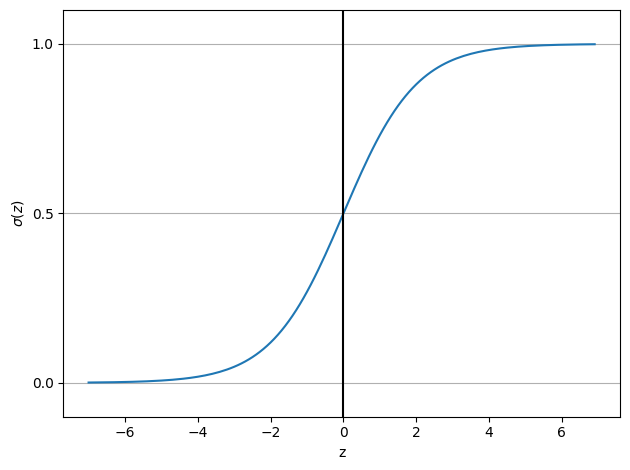

In [3]:
z = np.arange(-7, 7, 0.1)
sigma_z = sigmoid(z)
plt.plot(z, sigma_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel(r'$\sigma (z)$')
# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

We can see that $\sigma(z)$ approaches 1 if $z$ goes toward infinity $(z \to \infty)$ since $e^{-z}$ becomes very small for large values of $z$. Similarly, $\sigma(z)$ goes toward 0 for $z \to -\infty$ as a result of an increasingly large denominator. Thus, we can conclude that this sigmoid function takes real-number values as input and transforms them into values in the range $[0, 1]$ with an intercept at $\sigma(0) = 0.5$.

## Learning the weights via the logistic loss function

In [4]:
def loss_1(z):
    return -np.log(sigmoid(z))
def loss_0(z):
    return -np.log(1-sigmoid(z))

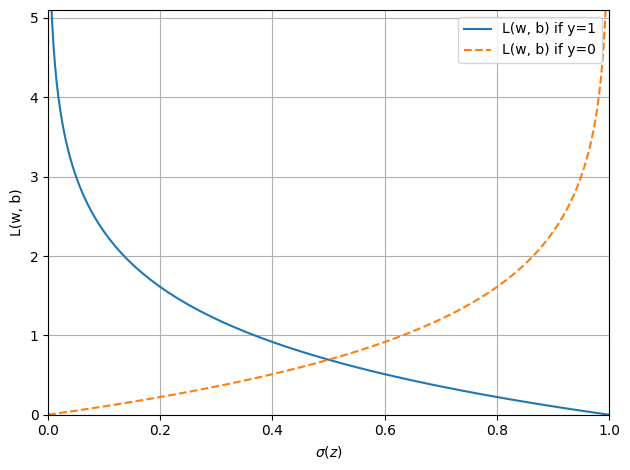

In [5]:
z = np.arange(-10, 10, 0.1)
sigma_z = sigmoid(z)
c1 = [loss_1(x) for x in z]
plt.plot(sigma_z, c1, label='L(w, b) if y=1')
c0 = [loss_0(x) for x in z]
plt.plot(sigma_z, c0, linestyle='--', label='L(w, b) if y=0')
plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel(r'$\sigma(z)$')
plt.ylabel('L(w, b)')
plt.legend(loc='best')
plt.grid()
plt.tight_layout()
plt.show()

We can see that the loss approaches 0 (continuous line) if we correctly predict that an example belongs to class 1. Similarly, we can see on the y axis that the loss also approaches 0 if we correctly predict y = 0 (dashed line). However, if the prediction is wrong, the loss goes toward infinity. The main point is that we penalize wrong predictions with an increasingly larger loss.

## Load data

In [2]:
iris_df = load_iris()
X, y = iris_df.data[:, [2, 3]], iris_df.target
print('Class labels:', np.unique(y))

Class labels: [0 1 2]


## Train & Test split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
# This shuffle data
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


## Standarize

In [4]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [5]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

## Train Model

In [6]:
lrgd = LogisticRegressionGD(
    eta=0.3,
    n_iter=3000,
    random_state=1
)
lrgd.fit(X_train_01_subset, y_train_01_subset)

## Evaluate model

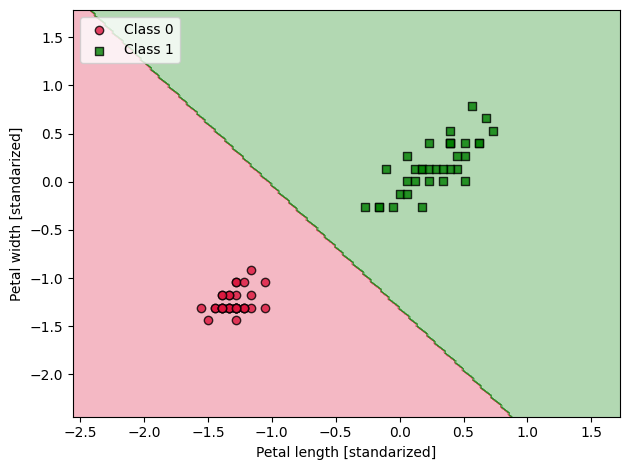

In [7]:
plot_decision_boundary(
    X=X_train_01_subset,
    y=y_train_01_subset,
    classifier=lrgd,
    x_label='Petal length [standarized]',
    y_label='Petal width [standarized]'
)

## Train a Logistic Regression with Sckit-Learn

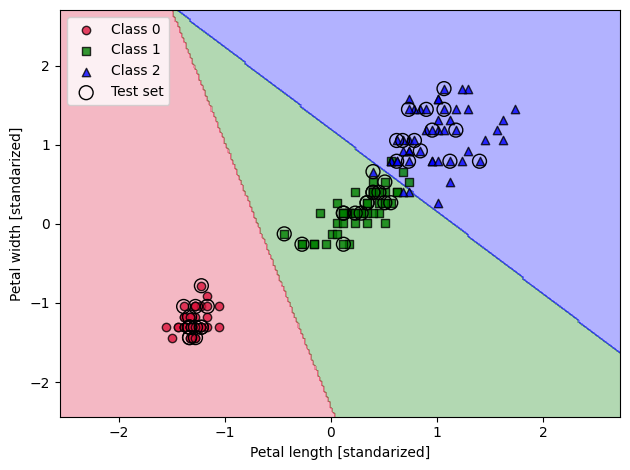

In [10]:
lr = LogisticRegression(
    C=100,
    solver='lbfgs'
)
multiclass = OneVsRestClassifier(
    estimator=lr
)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
multiclass.fit(X_train_std, y_train)
plot_decision_boundary(
    X_combined_std,
    y_combined,
    multiclass,
    test_idx=range(105,150),
    x_label='Petal length [standarized]',
    y_label='Petal width [standarized]'
)

The probability that training examples belong to a certain class can be computed using the `predict_proba` method. For example, we can predict the probabilities of the first three examples in the test dataset as follows:

In [11]:
multiclass.predict_proba(X_test_std[:3, :])

array([[6.63770505e-09, 1.44747233e-01, 8.55252760e-01],
       [8.34031210e-01, 1.65968790e-01, 3.20815954e-13],
       [8.48822884e-01, 1.51177116e-01, 2.57998350e-14]])

The first row corresponds to the class membership probabilities of the first flower, the second row corresponds to the class membership probabilities of the second flower, and so forth. Notice that the column-wise sum in each row is 1, as expected. **(You can confirm this by executing lr.predict_proba(X_test_std[:3, :]).sum(axis=1).)**

In [13]:
multiclass.predict_proba(X_test_std[:3, :]).sum(axis=1)

array([1., 1., 1.])

The highest value in the first row is approximately 0.85, which means that the first example belongs to class 3 (Iris-virginica) with a predicted probability of 85 percent. So, as you may have already noticed, we can get the predicted class labels by identifying the largest column in each row, for ex￾ample, using NumPy’s argmax function:

In [14]:
multiclass.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0])

In practice, the more convenient way of obtaining class labels when using scikit-learn is to call the predict method directly:

In [15]:
multiclass.predict(X_test_std[:3, :])

array([2, 0, 0])

Lastly, a word of **caution** if you want to predict the class label of a single flower example: **scikit-learn expects a two-dimensional array as data input; thus, we have to convert a single row slice into such a format first**. One way to convert a single row entry into a two-dimensional data array is to use NumPy’s reshape method to add a new dimension, as demonstrated here:

In [16]:
multiclass.predict(X_test_std[0, :])

ValueError: Expected 2D array, got 1D array instead:
array=[0.89820289 1.44587881].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [17]:
multiclass.predict(X_test_std[0, :].reshape(1, -1))

array([2])

In [18]:
X_test_std[0, :], X_test_std[0, :].reshape(1, -1)

(array([0.89820289, 1.44587881]), array([[0.89820289, 1.44587881]]))